<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Plotting-emissivity-data-and-modeling-as-sigmoid-function-with-Bayes-analysis" data-toc-modified-id="Plotting-emissivity-data-and-modeling-as-sigmoid-function-with-Bayes-analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Plotting emissivity data and modeling as sigmoid function with Bayes analysis</a></span><ul class="toc-item"><li><span><a href="#Visually-explore-data" data-toc-modified-id="Visually-explore-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Visually explore data</a></span></li><li><span><a href="#Fitting-data-to-sigmoid-function" data-toc-modified-id="Fitting-data-to-sigmoid-function-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Fitting data to sigmoid function</a></span></li></ul></li></ul></div>

In [55]:
import pandas as pd
import pymc3 as pm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Plotting emissivity data and modeling as sigmoid function with Bayes analysis
This notebook outlines a method for solving for emissivity in the thermal decay region. The thermal decay region occurs when input power is shut off and the heated substrate begins to cool by emitting heat as radiation. The following steps outline how to solve for emissivity given temperature and time data. 

1. Visaully explore data
2. Solve Emissivity 

## Visually explore data
Below five dataframes are loaded with recorded data. The data were recorded in .txt files and tab delimited. Temperature was recorded in Celcius and time intervals are 500ms. From the plot below we see that the flat locations are the steady-state regions. Following steady-state are the regions of thermal decay. 


In [2]:
# Create a function to load a list of csv files into individual dataframes
def csv_to_df(csv_list):
    '''Takes a list of input csv files as strings. Converts the file names to pandas dataframes.
    The data frames are assigned names df1, df2, df3...dfn'''
    # make a list of dataframes
    df_list = ['df' + str(item) for item in range(1, len(csv_list) + 1)]
    for x, y in zip(df_list, csv_list):
        globals()[x] = pd.read_csv(y, header=None,names=['Time', 'Temp'],  delimiter='\t')

In [31]:
files = ['../data/2014.12.17 OneEigth in Si post', '../data/2014.12.17 OneFourth in Si post',
         '../data/2014.12.17 OneHalf in Si post', '../data/2014.12.17 ThreeFourths in Si post',
         '../data/2014.12.17 One in Si post']
csv_to_df(files)

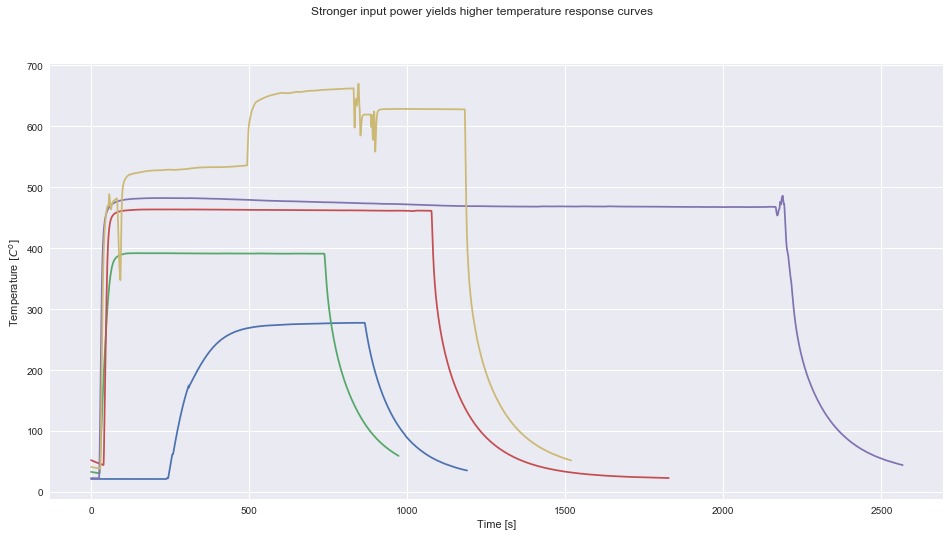

In [32]:
# Plot all Temperature versus Time curves
fig = plt.figure(figsize=(16, 8))
plt.xlabel('Time [s]')
plt.ylabel('Temperature $[C^o]$')
fig.suptitle('Stronger input power yields higher temperature response curves')
plt.plot(df1.Time, df1.Temp, df2.Time, df2.Temp, df3.Time,
         df3.Temp, df4.Time, df4.Temp, df5.Time, df5.Temp)
plt.show()

Isolating the thermal decay curve with a time condition executed near the end of the steady-state region from above. 

In [33]:
df1 = df1[(df1.Time > 800)]
df2 = df2[(df2.Time > 700)]
df3 = df3[(df3.Time > 1000)]
df4 = df4[(df4.Time > 2200)]
df5 = df5[(df5.Time > 1100)]

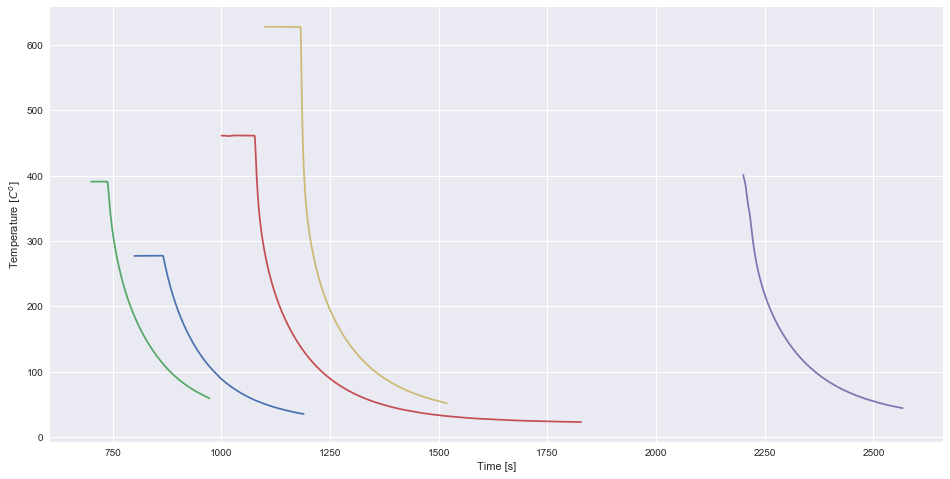

In [34]:
# Plot all Temperature versus Time curves
fig = plt.figure(figsize=(16, 8))
plt.xlabel('Time [s]')
plt.ylabel('Temperature $[C^o]$')
plt.plot(df1.Time, df1.Temp, df2.Time, df2.Temp, df3.Time,
         df3.Temp, df4.Time, df4.Temp, df5.Time, df5.Temp)
plt.show()

In [23]:
def em_column(df):
    '''This function takes a column which contains Temperature and Time data. 
    With the data, the function extrapolates for emissivity by invoking
    a numerical 2-point derivative. '''
    #Reset the index for easy iteration 
    df.reset_index(inplace = True, drop = True)
    
    #Constants: sigma [J/(m^2*s*K^4)]; m, mass in kilograms; T0 in K; A, area in m^2
    a = 0.0002
    T0 = 22 + 273.15
    sigma = 5.670373e-08  
    m = 0.0000693  
    
      #Converts Celcius to Kelvin
    df['TempK'] = df['Temp'] + 273.15 
    
    #heat capacity for silicon as a function of temperature. 
    #Chase, M.W., Jr., NIST-JANAF Themochemical Tables, Fourth Edition, J. Phys. Chem. Ref. Data, Monograph 9, 1998, 1-1951.
    #Cp° = A + B*t + C*t2 + D*t3 + E/t2
    #t = T (K)/1000
    #moles in a gram 28.0855
    c = lambda x: ( 22.81719 + 3.89951*( x / 1000 ) - 0.082885*( x/1000)**2 + 0.04211*(x/1000)**3 - 0.354063/( ( x/1000)**2 ) ) /28.0855*1000
    
    #Gives 'em'  column correct length
    df[ 'em' ] = np.nan
    
    #Solve for heat capacity 
    df[ 'Cp'] = c( df.TempK )
    
    #iterate through columns and solve for emissivity        
    for i in range(1, len(df) -1):
        num_derivative =  ( df.Temp[i +1] - df.Temp[i - 1] )*( df.Time[ i+1] - df.Time[i-1] )
        numerator =  -m*( df[ 'Cp' ][i] ) * num_derivative
        denom =  a*sigma*( df.TempK[ i ]**4 - T0**4 )
        df['em'][i] = numerator / denom       
        
    #Make temperature ascending 
    #df.sort_values(['Temp'], ascending=True, inplace =True)
    #Reset the index for easy data cleaning 
    #df.reset_index(inplace = True, drop = True)

In [35]:
#Solve emissivity for all data sets 
em_column(df1)
em_column(df2)
em_column(df3)
em_column(df4)
em_column(df5)

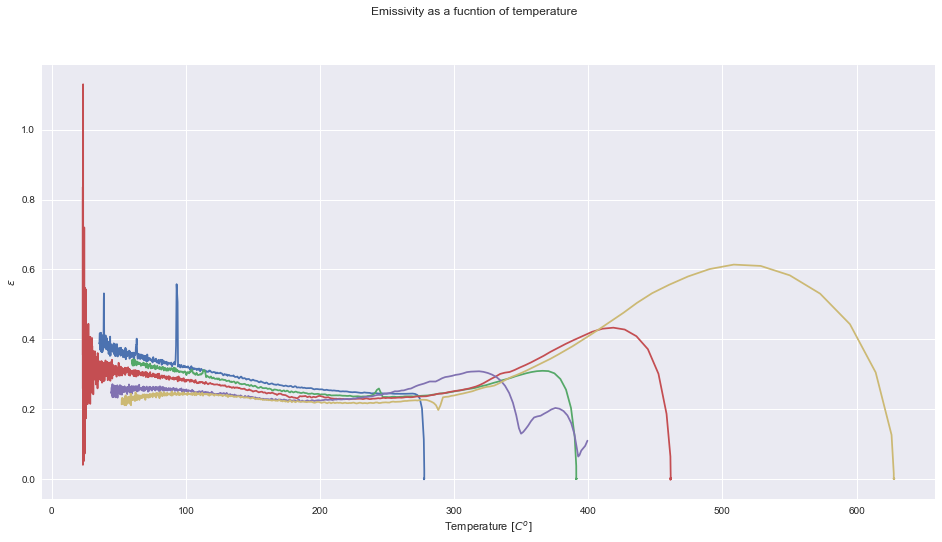

In [36]:
#Plot all emissivities 
fig = plt.figure(figsize=(16, 8))
plt.xlabel('Temperature $[C^o]$')
plt.ylabel('$\epsilon$')
fig.suptitle('Emissivity as a fucntion of temperature')
plt.plot(df1.Temp, df1.em, df2.Temp, df2.em, df3.Temp, df3.em, df4.Temp, df4.em,df5.Temp,df5.em )
plt.show()

In [74]:
# Combining all the data frames into a single data frame 
df = pd.concat( [ df1[['Temp','em']], df2[['Temp','em']], 
                 df3[['Temp','em']], df4[['Temp','em']],
                 df5[['Temp','em']] ], ignore_index = True)

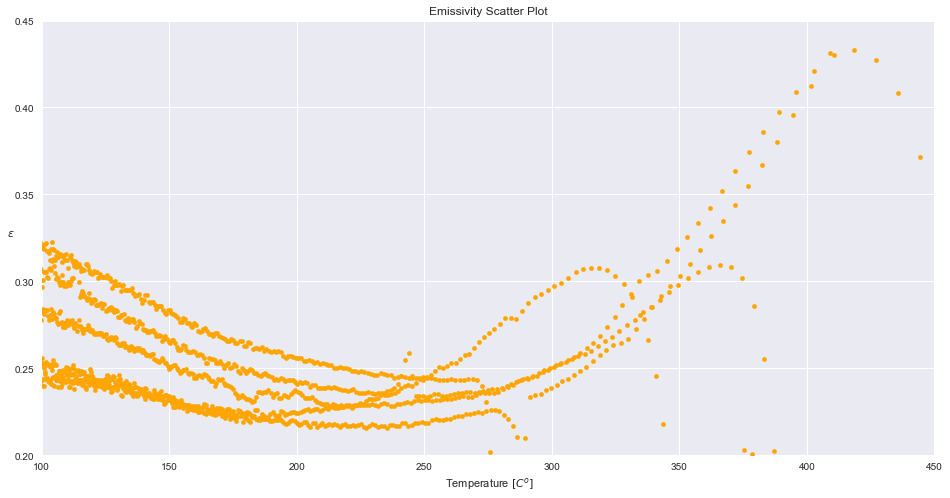

In [75]:
df.plot.scatter(y = 'em', x = 'Temp', color = 'orange', 
                ylim = (0.2,.45),  xlim = (100,450), 
                legend = False, figsize=(16,8), 
                title ='Emissivity Scatter Plot')
plt.xlabel(' Temperature $[C^o]$', rotation = 0)
plt.ylabel('$\epsilon$', rotation = 0);

## Fitting data to sigmoid function 
Next we need to clean up the data by combining into a single data frame, and dropping the smaller temperature values. The smaller temperature values greatly contribute to noise, thus we drop them.  After that data is cleaned we use it to fit a sigmoid function using Bayes inference. 

In [39]:
#Clean up data by dropping NaN and sorting by Temperature values. 
df.sort_values(by='Temp', inplace = True)
df.dropna(axis=0, how='any', inplace =True )
df = df[  (df.Temp > 250)]

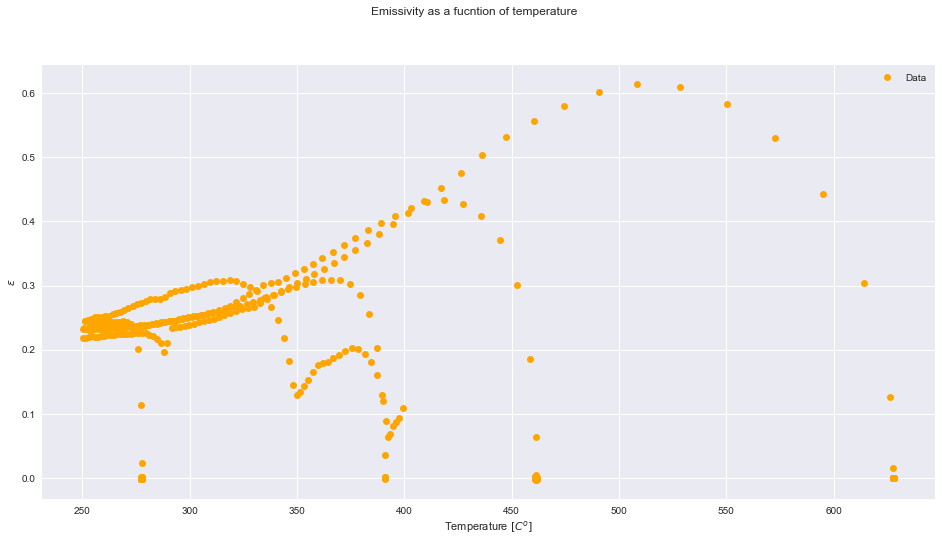

In [47]:
fig = plt.figure(figsize=(16, 8))
plt.xlabel('Temperature $[C^o]$')
plt.ylabel('$\epsilon$')
fig.suptitle('Emissivity as a fucntion of temperature')
plt.plot(df['Temp'], df['em'], 'o' , color ='orange', label = 'Data')
plt.legend();

The plot below models an ideal sigmoid curve with respective parameters. Below this plot we can begin to model the sigmoid function using our emissivity data. 

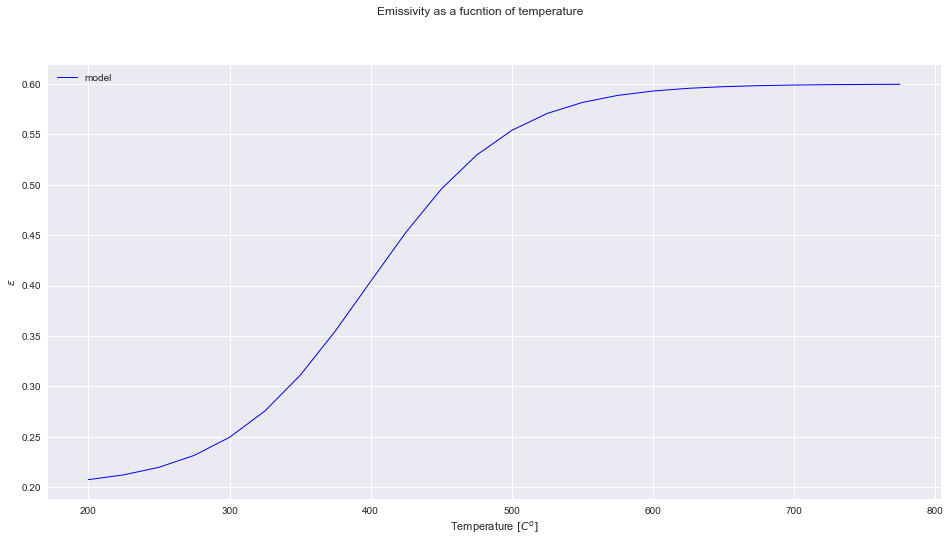

In [51]:
x = np.arange(200,800,25)

# Parameters for sigmoid
y_intercept = 0.2
s_amp = .4
x_coef = .02
x_offset =  7.957

#Sigmoid function 
sigmoid = lambda x, amp, coef, offset,intercept: intercept + amp*( 1/(1+np.exp(-x*coef + offset)) )
s_true = sigmoid(x = x, amp = s_amp, coef = x_coef, offset = x_offset, intercept = y_intercept)

fig = plt.figure(figsize=(16, 8))
plt.xlabel('Temperature $[C^o]$')
plt.ylabel('$\epsilon$')
fig.suptitle('Emissivity as a fucntion of temperature')
plt.plot(x,s_true,'b', marker='None', ls='-', lw=1, label='model')
plt.legend();

In [54]:
# Arranging data for bayes with pymc 
s = np.asarray(df['em'])
x = np.asarray(df['Temp'])

In [71]:
with pm.Model() as model3:
    intercept = 0.21 #pm.Uniform('intercept', 0.05, 0.4)
    amp = 0.589 #pm.Uniform('amp', 0, 1)
    coef = pm.Uniform('coef', 0,1)
    offset = 8.862 #pm.Uniform('offset', 0, 10, testval= 8.5)
    tau = pm.Uniform('tau', 0, 1000)


    sigmoid=pm.Deterministic('sigmoid', intercept + amp*( 1/(1+np.exp(-x*coef + offset)) ) )

    y =pm.Normal('y', mu=sigmoid, tau=tau, observed=s)

  
    trace=pm.sample(2000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 10,183:   5%|▍         | 9972/200000 [00:02<00:54, 3460.66it/s]
Convergence archived at 10100
Interrupted at 10,100 [5%]: Average Loss = 41,338
 99%|█████████▉| 2968/3000 [00:08<00:00, 335.07it/s]/Users/cristian/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 3000/3000 [00:08<00:00, 351.09it/s]


NameError: name 's_error' is not defined

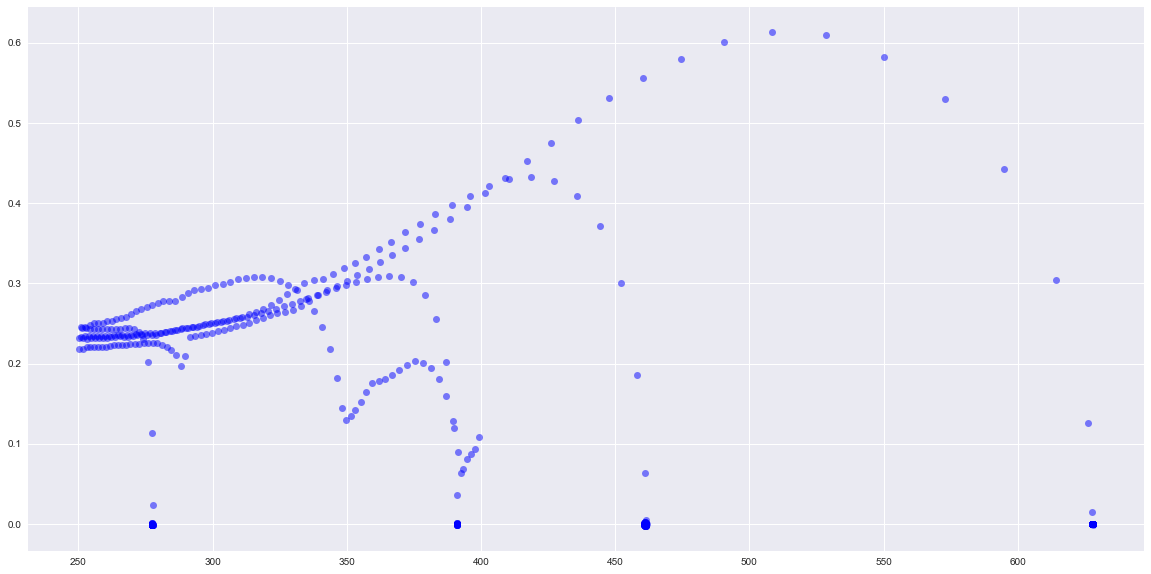

In [73]:
# extract and plot results
plt.figure(figsize=(20,10))
y_min = np.percentile(trace.sigmoid,2.5,axis=0)
y_max = np.percentile(trace.sigmoid,97.5,axis=0)
y_fit = np.percentile(trace.sigmoid,50,axis=0)
plt.plot(df['Temp'],df['em'],'b',  alpha=0.5, marker='o',ls='None', label='True')
plt.errorbar(x,s,yerr=s_error, color='r', marker='.', ls='None', label='Observed')
plt.plot(df['Temp'],y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit')
plt.fill_between(df['Temp'], y_min, y_max, color='0.5', alpha=0.5)
plt.plot(x,s_true,'orange', marker='None', ls='-', lw=1, label='model')

#plt.legend();

In [ ]:
summary(trace)

In [ ]:
x = np.arange(200,800,25)

# Parameters for tanh
y_intercept = 0.21
s_amp = .589
x_coef = .021
x_offset =  8.862

#Sigmoid function 
sigmoid = lambda x, amp, coef, offset,intercept: intercept + amp*( 1/(1+np.exp(-x*coef + offset)) )
s_true = sigmoid(x = x, amp = s_amp, coef = x_coef, offset = x_offset, intercept = y_intercept)

plt.plot(x,s_true,'b', marker='None', ls='-', lw=1, label='model')
plt.legend();